<a href="https://colab.research.google.com/github/adenurchalisa/Capstone-Model/blob/main/model_prediksi_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
# 1. Mount Google Drive (jika di Colab)
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:

file_path = '/content/drive/MyDrive/capstoneku/data_transaksi_advanced.csv'
df = pd.read_csv(file_path)
df['tanggal'] = pd.to_datetime(df['tanggal'])

In [4]:

df = df.drop(columns=['rating', 'anomaly_flag', 'id_transaksi'])
df['bulan'] = df['tanggal'].dt.month
df['tahun'] = df['tanggal'].dt.year
df['hari'] = df['tanggal'].dt.day
df['hari_ke'] = df['tanggal'].dt.dayofweek
df['jam'] = pd.to_datetime(df['waktu'], format='%H:%M').dt.hour
df = df.drop(columns=['tanggal', 'waktu'])

In [5]:
le_profil = LabelEncoder()
df['profil_enc'] = le_profil.fit_transform(df['profil'])
le_mp = LabelEncoder()
df['metode_pembayaran_enc'] = le_mp.fit_transform(df['metode_pembayaran'])
le_lokasi = LabelEncoder()
df['lokasi_enc'] = le_lokasi.fit_transform(df['lokasi'])

In [6]:

df_pengeluaran = df[df['tipe'] == 'keluar'].copy()

In [7]:

agg = df_pengeluaran.groupby(['user_id', 'tahun', 'bulan']).agg(
    total_pengeluaran=('nominal', 'sum'),
    jumlah_transaksi=('nominal', 'count'),
    rata2_transaksi=('nominal', 'mean'),
    profil_enc=('profil_enc', 'first'),
    metode_pembayaran_enc=('metode_pembayaran_enc', lambda x: x.mode()[0] if len(x) else 0),
    lokasi_enc=('lokasi_enc', lambda x: x.mode()[0] if len(x) else 0)
).reset_index()

agg = agg.sort_values(['user_id', 'tahun', 'bulan'])

In [8]:

agg['pengeluaran_bulan_lalu'] = agg.groupby('user_id')['total_pengeluaran'].shift(1)
agg['rolling3_pengeluaran'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).mean().shift(1).values

In [9]:

agg['rolling3_std'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).std().shift(1).values
agg['rolling3_min'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).min().shift(1).values
agg['rolling3_max'] = agg.groupby('user_id')['total_pengeluaran'].rolling(window=3, min_periods=1).max().shift(1).values

In [10]:

agg['trend_bulan'] = (agg['total_pengeluaran'] - agg['pengeluaran_bulan_lalu']) / (agg['pengeluaran_bulan_lalu'] + 1)

In [11]:

agg['target'] = agg.groupby('user_id')['total_pengeluaran'].shift(-1)

In [12]:

agg = agg.dropna(subset=['target', 'pengeluaran_bulan_lalu', 'rolling3_pengeluaran', 'rolling3_std', 'rolling3_min', 'rolling3_max', 'trend_bulan']).reset_index(drop=True)

In [13]:

train = agg[agg['tahun'] < 2024]
test = agg[agg['tahun'] == 2024]

fitur = [
    'total_pengeluaran', 'jumlah_transaksi', 'rata2_transaksi',
    'profil_enc', 'metode_pembayaran_enc', 'lokasi_enc', 'bulan',
    'pengeluaran_bulan_lalu', 'rolling3_pengeluaran',
    'rolling3_std', 'rolling3_min', 'rolling3_max', 'trend_bulan'
]

X_train = train[fitur]
y_train = train['target']
X_test = test[fitur]
y_test = test['target']

In [14]:

y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [15]:
# 2. Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150, 200, 250, 300],
    'max_depth': [2, 3, 4, 5, 6],
    'learning_rate': [0.01, 0.05, 0.1, 0.15, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5, 10]
}

xgb_base = XGBRegressor(random_state=42, n_jobs=-1)

In [16]:
# 3. TimeSeriesSplit untuk validasi yang adil pada data deret waktu
tscv = TimeSeriesSplit(n_splits=3)

random_search = RandomizedSearchCV(
    estimator=xgb_base,
    param_distributions=param_grid,
    n_iter=20,  # jumlah kombinasi yang akan dicoba, bisa diperbesar untuk hasil lebih optimal
    scoring='neg_mean_absolute_error',
    cv=tscv,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

In [17]:
# 4. Tuning pada data training (pakai target log)
random_search.fit(X_train, y_train_log)

print("Best parameters found:")
print(random_search.best_params_)

Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best parameters found:
{'subsample': 0.6, 'n_estimators': 100, 'max_depth': 4, 'learning_rate': 0.1, 'gamma': 5, 'colsample_bytree': 0.8}


In [18]:
# 5. Evaluasi pada data test
best_model = random_search.best_estimator_
y_pred_log = best_model.predict(X_test)
y_pred = np.expm1(y_pred_log)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

mask = y_test > 200000
if mask.sum() > 0:
    mape_200k = np.mean(np.abs((y_test[mask] - y_pred[mask]) / y_test[mask])) * 100
    print(f"MAPE (target > 200k): {mape_200k:.2f}%")
else:
    print("Tidak ada data target > 200 ribu.")

MAE: 5985045.62
RMSE: 10268534.37
MAPE: 392.60%
MAPE (target > 200k): 149.89%


In [19]:
# 6. Baseline untuk perbandingan
baseline_pred = X_test['pengeluaran_bulan_lalu']
baseline_mae = mean_absolute_error(y_test, baseline_pred)
baseline_mape = np.mean(np.abs((y_test - baseline_pred) / y_test)) * 100
print(f"Baseline MAE: {baseline_mae:.2f}, Baseline MAPE: {baseline_mape:.2f}%")

Baseline MAE: 8093284.09, Baseline MAPE: 674.36%


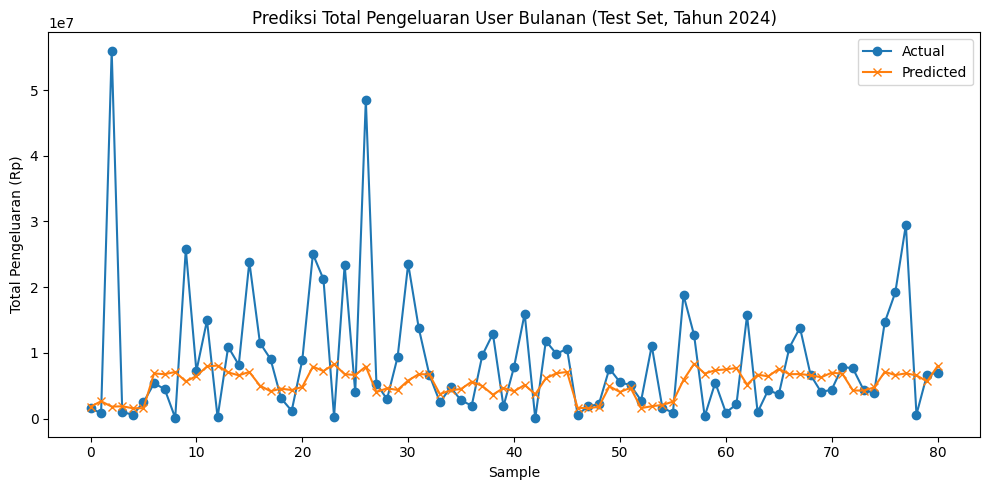

In [20]:
# 7. Visualisasi (opsional, sama seperti sebelumnya)
plt.figure(figsize=(10,5))
plt.plot(y_test.values, label='Actual', marker='o')
plt.plot(y_pred, label='Predicted', marker='x')
plt.legend()
plt.title('Prediksi Total Pengeluaran User Bulanan (Test Set, Tahun 2024)')
plt.xlabel('Sample')
plt.ylabel('Total Pengeluaran (Rp)')
plt.tight_layout()
plt.show()